<a href="https://colab.research.google.com/github/HNXJ/GSDR/blob/main/Jaxley_Mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jaxley Biophysical model mechanisms

This notebook contains definitions of biophysical mechanisms to be used in Jaxley https://jaxley.readthedocs.io/en/

@HNyXJ (Assisted by Vanderbilt's amplify AI and Google's Gemini)

Mechanisms included or to be implemented in this notebook :

GABAa

GABAb

AMPA

NMDA

ACh

D1

D2

5HT



In [8]:
%pip install jaxley

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

from jax import jit, vmap, value_and_grad

import jaxley as jx
from jaxley.channels import Leak, HH
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import fully_connect

# Neuronal mechanisms


## GABAa


In [10]:
import jax.numpy as jnp
from jaxley.synapses import Synapse

class GradedGABAa(Synapse):
    """
    A graded (non-spiking) GABAa synapse model based on high-threshold
    graded transmission dynamics.

    Unlike standard exponential synapses which are triggered by spike events,
    this mechanism's gating variable 's' is continuously driven by the
    presynaptic voltage via a hyperbolic tangent transfer function.

    Dynamics:
        ds/dt = -s/tauD + (1/2) * (1 + tanh((V_pre - V_th) / slope)) * ((1-s)/tauR)
        I_syn = gGABAa * s * (V_post - EGABAa)

    Parameters:
        gGABAa (float): Peak synaptic conductance [uS or mS/cm^2 depending on context].
        EGABAa (float): Reversal potential [mV]. Default: -80.0.
        tauD   (float): Decay time constant [ms]. Default: 10.0.
        tauR   (float): Rise time constant [ms]. Default: 0.2.
        V_th   (float): Half-activation voltage [mV]. Default: 0.0 (centered tanh).
        slope  (float): Sensitivity of the activation curve [mV]. Default: 10.0.

    References:
        1. Golowasch, J., Casey, M., Abbott, L. F., & Marder, E. (1999).
           Network stability from neuronal insight. Journal of Neurobiology, 41(3), 331-348.
        2. Prinz, A. A., Bucher, D., & Marder, E. (2004).
           Similar network activity from disparate circuit parameters.
           Nature Neuroscience, 7(12), 1345-1352.
    """

    def __init__(self, name: str = "GradedGABAa"):
        super().__init__(name)

        # Parameter definitions matching DynaSim defaults
        self.synapse_params = {
            "gGABAa": 0.25,
            "EGABAa": -80.0,
            "tauD": 10.0,
            "tauR": 0.2,
            "slope": 10.0,  # Denominator inside the tanh
            "V_th": 0.0     # Midpoint of the tanh (implicit 0 in DynaSim)
        }

        # Initial Condition (IC) matching DynaSim IC=[0.1]
        self.synapse_states = {"s": 0.1}

    def update_states(self, states, dt, pre_v, post_v, params):
        """
        Updates the gating variable 's' based on PRE-synaptic voltage.
        """
        s = states["s"]
        tauD = params["tauD"]
        tauR = params["tauR"]
        slope = params["slope"]
        v_th = params["V_th"]

        # The transfer function (Activation)
        # Corresponds to DynaSim: 1/2 * (1 + tanh(X_pre / 10))
        # We added V_th to make it more robust, but it defaults to 0.
        activation = 0.5 * (1 + jnp.tanh((pre_v - v_th) / slope))

        # Differential equation:
        # s' = -s/tauD + activation * (1-s)/tauR
        d_s = (-s / tauD) + activation * ((1 - s) / tauR)

        # Forward Euler integration
        new_s = s + d_s * dt

        return {"s": new_s}

    def compute_current(self, states, pre_v, post_v, params):
        """
        Calculates the synaptic current flowing into the POST-synaptic cell.
        """
        s = states["s"]
        g = params["gGABAa"]
        e_rev = params["EGABAa"]

        # Ohm's Law for the synapse
        current = g * s * (post_v - e_rev)

        return current

In [7]:
import jaxley as jx

# Instantiate the channel
gaba_mech = GABAa()

# Create a cell and add the mechanism
cell = jx.Cell()
cell.insert(gaba_mech)

# If you need to modify parameters specifically for this cell:
cell.GABAa.gGABAa = 0.5  # Override default conductance

RuntimeError: Unknown backend: 'gpu' requested, but no platforms that are instances of gpu are present. Platforms present are: cpu

In [ ]:
net.delete_recordings()
net.cell(0).branch(0).loc(0.0).record()
net.cell(1).branch(0).loc(0.0).record()
net.cell(2).branch(0).loc(0.0).record()

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


In [ ]:
inputs = jnp.asarray(np.random.rand(100, 2))
labels = jnp.asarray((inputs[:, 0] + inputs[:, 1]) > 1.0)

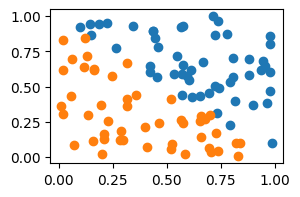

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.scatter(inputs[labels, 0], inputs[labels, 1])
_ = ax.scatter(inputs[~labels, 0], inputs[~labels, 1])

In [ ]:
labels = labels.astype(float)
# net.edges

In [ ]:
net.delete_trainables()
net.make_trainable("radius")
net.cell("all").branch("all").loc("all").make_trainable("Leak_gLeak")
net.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 60. Total number of trainable parameters: 61
Number of newly added trainable parameters: 100. Total number of trainable parameters: 161




*   II



In [ ]:
params = net.get_parameters()
s = jx.integrate(net, params=params, t_max=5.0)

In [ ]:
def simulate(params, inputs):
    currents = jx.datapoint_to_step_currents(i_delay=10.0, i_dur=40.0, i_amp=10*inputs, delta_t=0.025, t_max=100.0)

    data_stimuli = None
    data_stimuli = net.cell(0).branch(2).loc(1.0).data_stimulate(currents[0], data_stimuli=data_stimuli)
    data_stimuli = net.cell(1).branch(2).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)
    # data_stimuli = net.cell(3).branch(2).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)
    # data_stimuli = net.cell(4).branch(2).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli, delta_t=0.025)

batched_simulate = vmap(simulate, in_axes=(None, 0))

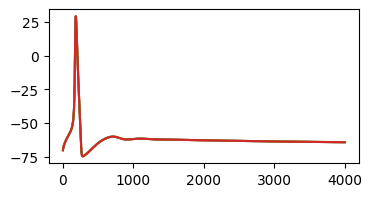

In [ ]:
traces = batched_simulate(params, inputs[:4])
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(traces[:, 2, :].T)

In [ ]:
def rasterPlot(params, inputs):
    """
    Plots a raster from the output of batched_simulate.

    Args:
        params: The network parameters.
        inputs: The input data for simulation (expected to be a batch, e.g., inputs[0:1]).
    """
    # Get simulation traces for the provided input batch.
    # If inputs has shape (1, D), then traces_batch will be (1, num_recordings, timepoints).
    traces_batch = batched_simulate(params, inputs)

    # Select all neuron traces for the first input in the batch.
    all_neuron_traces = traces_batch[0, :, :]  # Shape: (num_recordings, timepoints)

    # Define simulation time parameters (from cell xPLGrxkxUVUi)
    t_max = 100.0
    dt = 0.025
    time_axis = jnp.arange(0, t_max, dt)

    # Spike detection: detect when voltage crosses a threshold from below
    spike_threshold = -20.0 # Assuming a spike threshold of -20mV

    spike_times_list = []
    num_neurons = all_neuron_traces.shape[0]
    for i in range(num_neurons): # Iterate over each neuron (recording)
        neuron_trace = all_neuron_traces[i]
        # Find indices where voltage crosses threshold from below
        spikes = (neuron_trace[:-1] < spike_threshold) & (neuron_trace[1:] >= spike_threshold)
        spike_indices = jnp.where(spikes)[0]
        spike_times = time_axis[spike_indices + 1] # +1 because we are checking neuron_trace[1:]
        spike_times_list.append(spike_times)

    # Plotting the raster
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    for i, spk_times in enumerate(spike_times_list):
        ax.vlines(spk_times, i - 0.4, i + 0.4, colors='blue') # Plot vertical lines for each spike
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Neuron Index") # Changed label to reflect all neurons
    ax.set_title("Raster Plot of All Neurons for the First Input") # Changed title
    ax.set_yticks(jnp.arange(num_neurons)) # Set y-ticks to correspond to neuron indices
    ax.set_ylim(-0.5, num_neurons - 0.5)
    ax.set_xlim(0, t_max)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


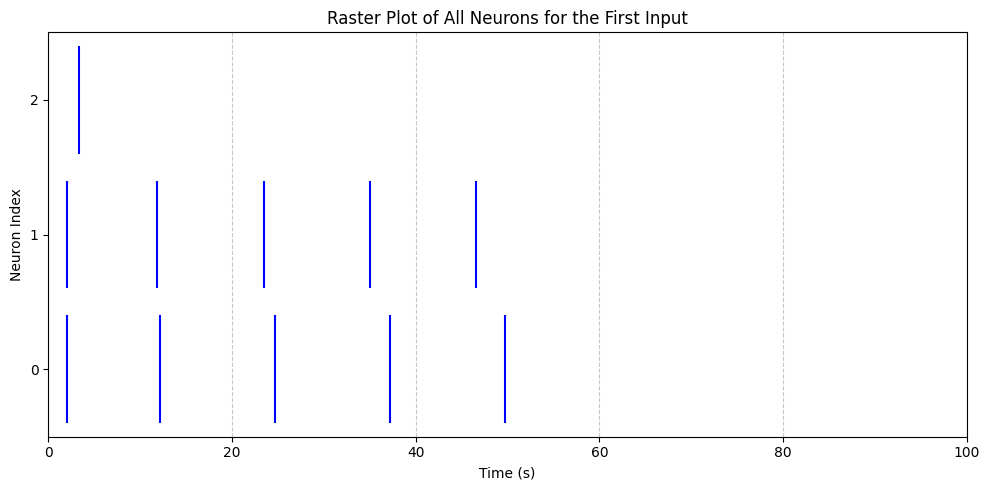

In [ ]:
# Call the rasterPlot function with the trained parameters and only the first input (as a batch)
rasterPlot(final_params, inputs[0:1])

In [ ]:
t_max = 100.0
dt = 0.025

levels = 2
time_points = t_max // dt + 2
checkpoints = [int(np.ceil(time_points**(1/levels))) for _ in range(levels)]

def simulate(params, inputs):
    currents = jx.datapoint_to_step_currents(i_delay=1.0, i_dur=1.0, i_amp=inputs / 10.0, delta_t=dt, t_max=t_max)

    data_stimuli = None
    data_stimuli = net.cell(0).branch(2).loc(1.0).data_stimulate(currents[0], data_stimuli=data_stimuli)
    data_stimuli = net.cell(1).branch(2).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli, checkpoint_lengths=checkpoints)

batched_simulate = vmap(simulate, in_axes=(None, 0))

def predict(params, inputs):
    traces = simulate(params, inputs)  # Shape `(batchsize, num_recordings, timepoints)`.
    prediction = jnp.mean(traces[2])  # Use the average over time of the output neuron (2) as prediction.
    return prediction + 72.0  # Such that the prediction is around 0.

batched_predict = vmap(predict, in_axes=(None, 0))

def predict_2(params, inputs):
    """
    Calculates the mean Power Spectral Density (PSD) of the average signal of all neurons
    response for frequencies in the range [0-100Hz].
    """
    traces = simulate(params, inputs)  # Shape `(num_recordings, timepoints)` when called by vmap
    signal = jnp.mean(traces, axis=0)  # Average across all neurons (axis=0)

    N = signal.shape[-1] # Number of time points
    fs = 1.0 / dt         # Sampling frequency

    # Compute one-sided FFT and corresponding frequencies for real signals
    signal_fft = jnp.fft.rfft(signal)
    freqs = jnp.fft.rfftfreq(N, d=dt)

    # Compute Power Spectral Density (PSD)
    # PSD = (1/(N*fs)) * |FFT(signal)|^2
    psd = (1.0 / (N * fs)) * jnp.abs(signal_fft)**2

    # Filter for frequencies in the range [0-100Hz]
    mask = (freqs >= 0) & (freqs <= 100)
    filtered_psd = psd[mask]

    # Return the mean of the filtered PSD as a scalar prediction.
    # Handle case where filtered_psd might be empty to avoid error in jnp.mean.
    return jnp.mean(filtered_psd) if filtered_psd.size > 0 else 0.0

batched_predict_2 = vmap(predict_2, in_axes=(None, 0))

def loss(opt_params, inputs, labels):
    params = transform.forward(opt_params)

    # Use the new predict_2 function for loss calculation
    predictions = batched_predict(params, inputs)
    losses = jnp.abs(predictions - labels)  # Mean absolute error loss.
    return jnp.mean(losses)  # Average across the batch.

jitted_grad = jit(value_and_grad(loss, argnums=0))

In [ ]:
params

[{'radius': Array([1.], dtype=float64)},
 {'Leak_gLeak': Array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001, 0.0001, 0.0001], dtype=float64)},
 {'IonotropicSynapse_gS': Array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
         0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.

In [ ]:
import jaxley.optimize.transforms as jt
# The structure passed to `jx.ParamTransform` should match the structure of `params`.
transform = jx.ParamTransform([
    {"radius": jt.SigmoidTransform(0.1, 5.0)},
    {"Leak_gLeak":jt.SigmoidTransform(1e-5, 1e-3)},
    {"IonotropicSynapse_gS" : jt.SigmoidTransform(1e-5, 1e-2)}
])

opt_params = transform.inverse(params)

In [ ]:
jitted_grad = jit(value_and_grad(loss, argnums=0))
value, gradient = jitted_grad(params, inputs[:4], labels[:4])

In [ ]:
import optax

key = jax.random.PRNGKey(42)
initial_params = net.get_parameters()

# Inner optimizer (Adam) handles the gradient descent part
optimizer_inner = optax.adam(learning_rate=0.01)

# Create GSDR wrapper
optimizer = GSDR.GSDR(
    inner_optimizer=optimizer_inner,
    delta_distribution=jax.random.normal,
    deselection_threshold=2.0,
    a_init=0.4,
    a_dynamic=True
)

# Initialize State
opt_state = optimizer.init(initial_params)

In [ ]:
class Dataset:
    """A simple Dataloader which returns batches of the data.

    Instead of using this simple dataloader, you can also just use one from
    PyTorch or Tensorflow. You do not have to understand what is going on here
    to follow this tutorial.
    """

    def __init__(self, inputs: np.ndarray, labels: np.ndarray):
        """Initialize the dataloader.

        Args:
            inputs: Array of shape (num_samples, num_dim)
            labels: Array of shape (num_samples,)
        """
        assert len(inputs) == len(labels), "Inputs and labels must have same length"
        self.inputs = inputs
        self.labels = labels
        self.num_samples = len(inputs)
        self._rng_state = None
        self.batch_size = 1

    def shuffle(self, seed=None):
        """Shuffle the dataset in-place"""
        self._rng_state = np.random.get_state()[1][0] if seed is None else seed
        np.random.seed(self._rng_state)
        indices = np.random.permutation(self.num_samples)
        self.inputs = self.inputs[indices]
        self.labels = self.labels[indices]
        return self

    def batch(self, batch_size):
        """Create batches of the data."""
        self.batch_size = batch_size
        return self

    def __iter__(self):
        """Iterate over the dataset."""
        self.shuffle(seed=self._rng_state)
        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            yield self.inputs[start:end], self.labels[start:end]
        self._rng_state += 1

In [ ]:
batch_size = 4
dataloader = Dataset(inputs, labels)
dataloader = dataloader.shuffle(seed=0).batch(batch_size)

# --- 5. Loop ---
key = jax.random.PRNGKey(0)
print("Starting training...")

for epoch in range(20):

    key, step_key = jax.random.split(key)
    epoch_loss = 0.0

    for batch_ind, batch in enumerate(dataloader):
        current_batch, label_batch = batch
        loss_val, gradient = jitted_grad(opt_params, current_batch, label_batch)
        updates, opt_state = optimizer.update(gradient, opt_state,
            params=params,   # Required for GSDR
            value=loss_val,      # Required for GSDR
            key=step_key)      # Required for GSDR
        opt_params = optax.apply_updates(opt_params, updates)
        epoch_loss += loss_val

    print(f"epoch {epoch}, loss {epoch_loss}, alpha {opt_state.a}")

final_params = transform.forward(opt_params)

Starting training...
epoch 0, loss 166.02349865808077, alpha 0.8976629765116264
epoch 1, loss 164.08156290693088, alpha 0.22411363313050225
epoch 2, loss 159.45938684081682, alpha 0.39708634584935965
epoch 3, loss 127.06109301543546, alpha 0.6754005720969567
epoch 4, loss 119.35827454531362, alpha 0.825688752641744
epoch 5, loss 116.64209462379293, alpha 0.9850565082087632
epoch 6, loss 113.93893856606437, alpha 0.03009050855879214
epoch 7, loss 112.41909635075586, alpha 0.4928100457585718
epoch 8, loss 111.95962002995753, alpha 0.991770845796139
epoch 9, loss 111.63895968136211, alpha 0.6314364778937669
epoch 10, loss 110.78202732629457, alpha 0.2789949646067431
epoch 11, loss 109.90128677919029, alpha 0.4992807027021253
epoch 12, loss 109.05493939673524, alpha 0.11873923733522851
epoch 13, loss 108.09505166867197, alpha 0.06801100585182596


In [ ]:
ntest = 32
# predictions = batched_predict(final_params, inputs[:4])

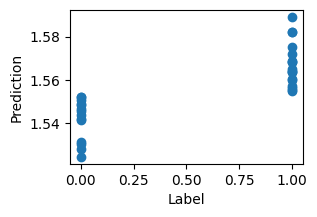

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.scatter(labels[:ntest], predictions)
_ = ax.set_xlabel("Label")
_ = ax.set_ylabel("Prediction")

In [ ]:
traces = batched_simulate(final_params, inputs[:4])
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(traces[:, 2, :].T)

# GSDR optimizer (optax standard format)

In [ ]:
import jax
import jax.numpy as jnp
import optax
from flax.struct import dataclass
from typing import Any, Callable, NamedTuple, Optional

# State (using flax dataclass for JIT compatibility)
@dataclass
class GSDRState:
    inner_state: Any         # State of the inner optimizer (e.g., SGD, AdaGrad, Adam ... state)
    params_opt: Any          # Best parameters so far (Optimal parameters)
    inner_state_opt: Any     # Inner optimizer state corresponding to the optimal parameters
    loss_opt: float          # Optimal loss
    a: float                 # Current self-supervision factor (alpha)
    a_opt: float             # Optimal self-supervision factor

def GSDR(
    inner_optimizer: optax.GradientTransformation,
    delta_distribution: Callable = jax.random.normal,
    deselection_threshold: float = 10.0,
    a_init: float = 0.5,
    a_dynamic: bool = True
) -> optax.GradientTransformation:
    """
    Optax-compliant implementation of the Genetic-Stochastic Delta Rule.

    Args:
        inner_optimizer: The gradient-based optimizer (e.g., optax.adam).
        delta_distribution: Function (key, shape) -> tensor for generating noise.
        deselection_threshold: Threshold factor to trigger genetic deselection.
        a_init: Initial self-supervision factor (0 to 1).
        a_dynamic: Whether 'a' should be stochastic/learnable.

    Returns:
        An optax.GradientTransformation (init_fn, update_fn).
    """

    def init_fn(params):
        inner_state = inner_optimizer.init(params)
        return GSDRState(
            inner_state=inner_state,
            params_opt=params,
            inner_state_opt=inner_state,
            loss_opt=jnp.inf,
            a=a_init,
            a_opt=a_init
        )

    def update_fn(updates, state, params=None, value=None, key=None):
        """
        Args:
            updates: Gradients from loss_fn (standard Optax naming).
            state: Current GSDRState.
            params: Current model parameters (Required).
            value: Current Loss value (Required for GSDR logic).
            key: JAX PRNGKey (Required for stochastic Delta).
        """
        if params is None:
            raise ValueError("GSDR requires 'params' to be passed to update().")
        if value is None:
            raise ValueError("GSDR requires current loss 'value' to be passed to update().")
        if key is None:
            raise ValueError("GSDR requires a random 'key' to be passed to update().")

        grads = updates
        loss = value

        # Split keys for delta noise and 'a' (exploration factor)
        delta_key, a_key = jax.random.split(key)

        # --- 1. Genetic Logic (Selection & Deselection) ---

        # Optimal loss selection
        is_new_opt = loss < state.loss_opt

        # Update Optimal State Candidates
        new_params_opt = jax.tree.map(
            lambda cur, opt: jnp.where(is_new_opt, cur, opt),
            params, state.params_opt
        )
        new_loss_opt = jnp.where(is_new_opt, loss, state.loss_opt)
        new_a_opt = jnp.where(is_new_opt, state.a, state.a_opt)

        # Keep the inner optimizer optimal state
        new_inner_state_opt = jax.tree.map(
            lambda cur, opt: jnp.where(is_new_opt, cur, opt),
            state.inner_state, state.inner_state_opt
        )

        # Deselection (Backtrack from the Catastrophic Failure)
        # If loss > threshold * best_loss, revert back to the optimal state
        # Exclude the case where loss_opt is infinity (start of training)
        is_deselect = (loss > (new_loss_opt * deselection_threshold)) & (new_loss_opt != jnp.inf)

        # --- 2. Determine Next Step Variables ---

        # If Deselecting: Revert 'a' to 'a_opt'. Else: Explore new 'a' (if a is dynamic)
        if a_dynamic:
            a_random = jax.random.uniform(a_key, minval=0.0, maxval=1.0)
            next_a = jnp.where(is_deselect, new_a_opt, a_random)
        else:
            next_a = state.a # Constant

        # If Deselecting: Revert inner_state to optimal. Else: Keep current.
        next_inner_state = jax.tree.map(
            lambda opt, cur: jnp.where(is_deselect, opt, cur),
            new_inner_state_opt, state.inner_state
        )

        # --- 3. Calculate Updates ---

        # A. Inner Optimizer Update (Gradient Descent)
        # Use the *potentially reverted* inner state
        inner_updates, updated_inner_state = inner_optimizer.update(grads, next_inner_state, params)

        # B. Stochastic Delta Update
        # Generate noise matching params structure
        param_leaves, treedef = jax.tree_util.tree_flatten(params)
        subkeys = jax.random.split(delta_key, len(param_leaves))
        param_keys_tree = jax.tree_util.tree_unflatten(treedef, subkeys)

        delta_noise = jax.tree.map(
            lambda p, k: delta_distribution(k, p.shape),
            params, param_keys_tree
        )
        # Scale noise by parameter magnitude (per paper/pseudocode)
        delta = jax.tree.map(lambda n, p: n * p, delta_noise, params)

        # C. Combine Updates: a * Grads + (1-a) * Delta
        # Note: 'next_a' is the 'a' for THIS step.
        combined_updates = jax.tree_map(
            lambda d, g: next_a * d + (1 - next_a) * g,
            delta, inner_updates
        )

        # --- 4. Handle Reset (The Revert Step) ---

        # If is_deselect is True, we want the FINAL params to be params_opt.
        # Optax applies: params_new = params + final_updates
        # So if reset: params_new = params_opt
        # Therefore: params + reset_update = params_opt
        # reset_update = params_opt - params

        reset_updates = jax.tree.map(
            lambda opt, cur: opt - cur,
            new_params_opt, params
        )

        # Select between Reset Update or Calculated Update
        final_updates = jax.tree.map(
            lambda reset, calc: jnp.where(is_deselect, reset, calc),
            reset_updates, combined_updates
        )

        # If deselected, must NOT advance the inner optimizer state
        # (use the reverted state).
        # If didn't deselect, use the state returned by inner_optimizer.update
        final_inner_state = jax.tree.map(
            lambda reset_st, advanced_st: jnp.where(is_deselect, reset_st, advanced_st),
            new_inner_state_opt, updated_inner_state
        )

        # Create new GSDR state
        new_state = GSDRState(
            inner_state=final_inner_state,
            params_opt=new_params_opt,
            inner_state_opt=new_inner_state_opt,
            loss_opt=new_loss_opt,
            a=next_a,
            a_opt=new_a_opt
        )

        return final_updates, new_state

    return optax.GradientTransformation(init_fn, update_fn)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from drive.MyDrive.Colab import GSDR